## Transfer learning & fine-tuning

So far we know about using pre-trained huggingface language models (e.g BERT, T5), in this part of the workshop we are going to talk about fine-tuning these pre-trained models for specific downstream NLP tasks (e.g. document classification (multiclass classification) and named-entity-recognition (NER). 

This is generally know as transfer learning. Transfer learning is a machine learning technique for adapting pretrained models to solve specialized problems. Sequential transfer learning is learning on one task, or one dataset, and then transferring this learning to another task or dataset.

#Hugging Face Hub (Optional):
If you want to easily share your model and integrate your trained model within the huggingface ecosystem then you can create an account at: 

https://huggingface.co/

This will allow you to push your model to the hub and then share and use it easily afterwards.



#Install git lfs:

In [ ]:
!apt-get update -y
!apt-get install git -y
!apt-get install git-lfs -y
!git lfs install

# Install dependencies

In [2]:
!pip install transformers datasets torch 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 22.7 MB/s 
     |████████████████████████████████| 365 kB 65.7 MB/s 
     |████████████████████████████████| 120 kB 69.0 MB/s 
     |████████████████████████████████| 6.6 MB 58.4 MB/s 
     |████████████████████████████████| 212 kB 71.3 MB/s 
     |████████████████████████████████| 115 kB 74.2 MB/s 
     |████████████████████████████████| 127 kB 75.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Dataset: The Yelp Review Full dataset for text classification.
Before we can fine-tune a pretrained model, we need to download a dataset and prepare it for training. We are going to use the Yelp dataset for fine-tuning. 

This dataset is a subset of businesses, reviews and user data.

The dataset contains text and the corresponding label (1-5 stars).



In [3]:
from datasets import load_dataset
dataset = load_dataset('yelp_review_full') 
dataset 


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset yelp_review_full downloaded and prepared to /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

**Datasets Yelp Review**

You can take a look at the dataset card [here](https://huggingface.co/datasets/yelp_review_full): 

In [4]:
dataset["train"].features

{'label': ClassLabel(num_classes=5, names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None),
 'text': Value(dtype='string', id=None)}

In [5]:
dataset["test"].features

{'label': ClassLabel(num_classes=5, names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None),
 'text': Value(dtype='string', id=None)}

Let's take a look at an example

In [6]:
dataset["train"][42]

{'label': 4,
 'text': 'What a find! I stopped in here for breakfast while in town for business. The service is so friendly I thought I was down south. The service was quick, frankly and felt like I was with family. \\nFantastic poached eggs, Cajun homefries and crispy bacon. Gab and Eat is definitely a place I world recommend to locals. I was stuffed and the bill was only $8.00.'}

In [7]:
dataset["test"][42]

{'label': 3,
 'text': "The decor is nothing fancy but the food is surprisingly good (and fresh). I've gotten takeout and eaten at the buffet. Both good for the price - it's inexpensive."}

Remember we need to process the text using a tokenizer, we will use padding and truncation to handle any variations in the sequence lengths. Why do we need to do this?

To reduce the time it takes for training we can create smaller subsets of the full dataset for fine-tuning

In [9]:
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1500))
small_eval_dataset = dataset["test"].shuffle(seed=42).select(range(150))

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', max_length=200)


In [11]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=200)

#tokenized_datasets = dataset.map(tokenize_function, batched=True)


*(Note: The primary purpose of [`map()`](https://huggingface.co/docs/datasets/process#map) is to speed up processing functions. It allows you to apply a processing function to each example in a dataset, independently or in batches. You can use it to apply the `tokenize_function()` to the data.*

*This will apply the function on all the elements of all the splits in dataset, so the train and test data will be preprocessed in one single command.)*

In [12]:
tokenized_train_dataset = small_train_dataset.map(tokenize_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [13]:
tokenized_eval_dataset = small_eval_dataset.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [14]:
print(tokenized_eval_dataset[7])

{'label': 3, 'text': "Stopped back by Mellow Mushroom with my mate Justin from Brew Bros. & a few of our mates Monday afternoon while pub crawling on a day off.  \\nFirst I must say my return trip was motivated by an immediate response from to my 1st Yelp review from Mellow Mushroom's owner Jay.  I didnt expect any reponse, much less a return so quickly. Respect for that. Great to see to someone paying such close attention to their customers.\\nThis can only be a good thing.\\nThe same draft selection as the first time around.  48 Handles.  Thats a lot of beer.  As said in my first reiview, with 48 handles I would Love to see more variety and a bit more imagination with respect to the draft beer choices, then again who would complain about a selection w/ at least 40 craft beers on tap?   Thats a real commitment. \\nOur bartender Madison was enthusiastic about what she was serving which in Arizona's growing craft beer community is a big plus.  On a another note, this time around the foo

In [15]:
#@title
#small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(20000))
#small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(2000))

In [16]:
a = tokenized_train_dataset["input_ids"]
import pandas as pd
df = pd.Series([len(aa) for aa in a])

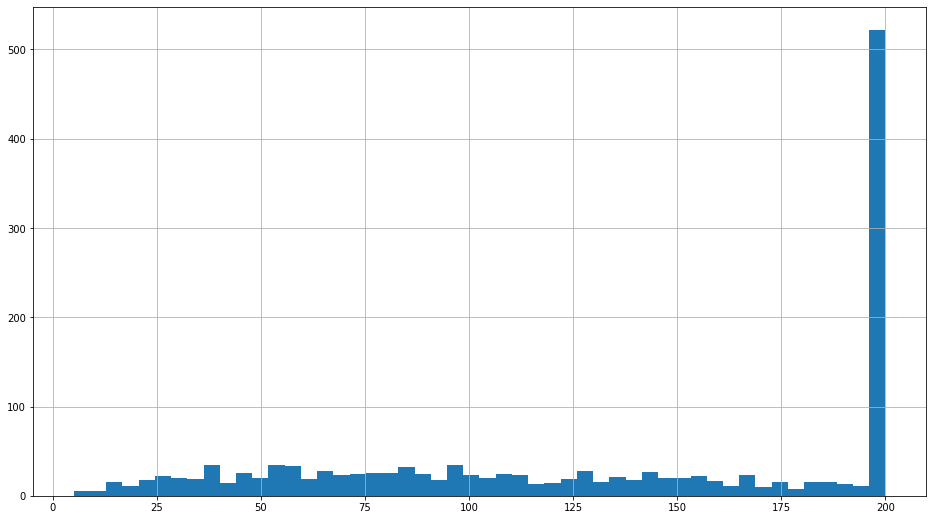

In [17]:
import matplotlib.pyplot as plt
df.hist(figsize=(16, 9), bins=50)

In [18]:
print(small_train_dataset[1])

{'label': 2, 'text': "who really knows if this is good pho or not, i was hung tha fuck over and in desperate need of pho therapy. :P but it totally hit the spot and came out super freakin fast!!! omg! aaahhhhh.....\\n\\ni'm pretty sure it wasn't bad pho tho...meat, noodles, broth, all a-ok. the coffee was good too. thought i was gettin ripped off for a $3 cup of coffee but they gave me a big cup so it's all good! :)\\n\\nima make pho a must the next time i go to vegas again fo sure!!! yum! :D"}


In [19]:
small_train_dataset

Dataset({
    features: ['label', 'text'],
    num_rows: 1500
})

In [20]:
small_eval_dataset

Dataset({
    features: ['label', 'text'],
    num_rows: 150
})

In [21]:
print(tokenized_train_dataset[0])

{'label': 4, 'text': "I stalk this truck.  I've been to industrial parks where I pretend to be a tech worker standing in line, strip mall parking lots, and of course the farmer's market.  The bowls are so so absolutely divine.  The owner is super friendly and he makes each bowl by hand with an incredible amount of pride.  You gotta eat here guys!!!", 'input_ids': [101, 146, 27438, 1142, 4202, 119, 146, 112, 1396, 1151, 1106, 3924, 8412, 1187, 146, 9981, 1106, 1129, 170, 13395, 7589, 2288, 1107, 1413, 117, 6322, 8796, 5030, 7424, 117, 1105, 1104, 1736, 1103, 9230, 112, 188, 2319, 119, 1109, 20400, 1132, 1177, 1177, 7284, 10455, 119, 1109, 3172, 1110, 7688, 4931, 1105, 1119, 2228, 1296, 7329, 1118, 1289, 1114, 1126, 10965, 2971, 1104, 8188, 119, 1192, 13224, 3940, 1303, 3713, 106, 106, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [22]:
tokenized_train_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1500
})

# Train
We will be using 🤗 Transformers [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) class for training. The API supports a wide range of training options & features.

First we need to load the model we are going to fine-tune for a classifcation task. We are using a BERT base model trained for sequence classification. Start by loading your model and specify the number of expected labels. From the Yelp Review [dataset card](https://huggingface.co/datasets/yelp_review_full#data-fields), we know there are five labels (0,1,2,3,4).

*The authors of BERT have released several versions of BERT pretrained on massive amounts of data, including a multilingual version which supports 104 languages in a single model. You can try these out in your spare time!*

In [23]:
from transformers import AutoModelForSequenceClassification
model_name = "bert-base-cased" 
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Think about what this warning is telling us ...

In [ ]:
#@title
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model.to(device)

To evaluate our models performance we need to pass the `Trainer` a function for computing and reporting the metrics, you can load different metrics with `load_metric()` (e.g. `accuracy`, `precision`, `recall`, `f1`).

Classification accuracy is the ratio of correct predictions to total predictions made.

In [24]:

from datasets import load_metric

metric = load_metric("accuracy")

Next is a call to the `compute` method on `metric` to calculate the prediction accuracies. Predictions must first be converted to `logits`, which are the raw predictions of the last layer of the neural network. Logits are the raw, unnormalized scores generated by the last layer of the model. To be converted to probabilities, they need to go through a SoftMax layer.

We can use the Argmax and SoftMax functions to make the output values from the neural network be between 0 and 1.
The `argmax()` function gets the largest number from the `logits`, which corresponds to the most likely class as predicted by the model.
The `softmax()` function gives us the probabilities for the predicted class.

In [25]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

To monitor the evaluation metrics during fine-tuning we need to specify an `evaluation_strategy` parameter in the training arguments, in this case at the end of an epoch.



We need to specify where to save the training checkpoints using the `TrainingArguments` class, this class contains all the hyperparameters

In [26]:
from transformers import TrainingArguments, Trainer
import numpy as np


training_args = TrainingArguments("Bert_Classifier",
                                  num_train_epochs=3,
                                  evaluation_strategy="epoch",
                                  overwrite_output_dir=True,
                                  #push_to_hub=True
                                  )

In [ ]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


Create a Trainer object specifying the model, training arguments, datasets and the evaluation function we defined above.

In [27]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

We are now ready to start fine-tuning the model for the text classification task, by calling the `train()` method.

In [28]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1500
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 564


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.089495,0.473333
2,No log,1.154130,0.500000
3,0.934100,1.188723,0.560000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 150
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 150
  Batch size = 8
Saving model checkpoint to Bert_Classifier/checkpoint-500
Configuration saved in Bert_Classifier/checkpoint-500/config.json
Model weights saved in Bert_Classifier/checkpoint-500/pytorch_model.bin
tokenizer config file saved in Bert_Classifier/checkpoint-500/tokenizer_config.json
Special tokens file saved in Bert_Classifier/checkpoint-500/specia

TrainOutput(global_step=564, training_loss=0.8809731395532053, metrics={'train_runtime': 181.2055, 'train_samples_per_second': 24.834, 'train_steps_per_second': 3.112, 'total_flos': 459934624248048.0, 'train_loss': 0.8809731395532053, 'epoch': 3.0})

In [ ]:
trainer.push_to_hub()


In [29]:
trainer.save_model("./bert_classify_model")

Saving model checkpoint to ./bert_classify_model
Configuration saved in ./bert_classify_model/config.json
Model weights saved in ./bert_classify_model/pytorch_model.bin
tokenizer config file saved in ./bert_classify_model/tokenizer_config.json
Special tokens file saved in ./bert_classify_model/special_tokens_map.json


In [38]:
model = AutoModelForSequenceClassification.from_pretrained("jenniferjane/Bert_Classifier")
#model = AutoModelForSequenceClassification.from_pretrained("./bert_classify_model")

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)
#input_text = "Last night we went to Hoppers in Marylebone and had an awful dinner, the food and service were dreadful, we had to wait a very long time. Very disappointing."
input_text = "The food is freakin awesome, the staff are bloody brilliant... We had great service and the drinks were out of this world! The chilli dosa are the mouthwateringly delicious. "
tokenized_text = tokenizer(input_text,
                            truncation=True,
                            is_split_into_words=False,
                            return_tensors='pt')
outputs = model(tokenized_text["input_ids"])
predicted_label = outputs.logits.argmax(-1)


loading configuration file https://huggingface.co/jenniferjane/Bert_Classifier/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7d679d23d22d6ffb312d13b0f12f382b0b545d1e1c69c09df276862485dac5e8.83e5c346117940eec8952f3bb08700d807e3afe285dc8abc02e6bf0ada06331b
Model config BertConfig {
  "_name_or_path": "jenniferjane/Bert_Classifier",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads

In [39]:
print(f'Review text: {input_text}')
print(f'Sentiment  : {predicted_label}')

Review text: The food is freakin awesome, the staff are bloody brilliant... We had great service and the drinks were out of this world! The chilli dosa are the mouthwateringly delicious. 
Sentiment  : tensor([4])


In [42]:
#@title

y_pred = outputs.logits.softmax(-1)

In [ ]:
#@title
y_pred

In [44]:
y_pred_argmax = outputs.logits.argmax(-1)


In [45]:
y_pred_argmax

tensor([4])

In [50]:
preds_output = trainer.predict(tokenized_eval_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 150
  Batch size = 8


In [51]:
# Get the predicted labels for the test set
y_preds = np.argmax(preds_output.predictions, axis=1)

In [48]:
preds_output.label_ids

array([2, 4, 1, 4, 3, 4, 2, 3, 2, 3, 0, 0, 3, 2, 2, 1, 3, 1, 2, 2, 1, 2,
       3, 1, 1, 3, 4, 0, 0, 2, 2, 2, 1, 3, 4, 0, 0, 1, 3, 2, 0, 2, 0, 0,
       3, 0, 3, 2, 3, 0, 1, 1, 3, 3, 4, 4, 1, 4, 1, 3, 1, 0, 0, 1, 4, 1,
       4, 3, 2, 4, 1, 0, 3, 3, 4, 1, 2, 1, 0, 4, 4, 4, 2, 3, 3, 1, 4, 0,
       4, 2, 3, 0, 0, 0, 3, 4, 0, 0, 1, 4, 4, 0, 0, 1, 1, 0, 4, 2, 2, 1,
       1, 4, 0, 4, 0, 3, 2, 0, 4, 4, 4, 2, 0, 0, 0, 1, 3, 0, 2, 0, 3, 2,
       2, 2, 0, 3, 4, 3, 0, 1, 0, 1, 0, 0, 4, 3, 3, 1, 3, 0])

In [49]:
y_preds

array([3, 3, 0, 4, 3, 4, 3, 3, 3, 3, 0, 0, 3, 1, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 1, 1, 4, 4, 0, 0, 2, 1, 2, 1, 0, 4, 3, 1, 1, 2, 4, 1, 1, 0, 1,
       3, 1, 3, 3, 3, 0, 1, 1, 3, 3, 3, 4, 0, 4, 2, 4, 1, 0, 0, 1, 3, 1,
       4, 4, 2, 4, 1, 1, 4, 3, 3, 2, 2, 1, 0, 3, 1, 3, 2, 2, 4, 2, 4, 1,
       4, 2, 3, 0, 1, 0, 2, 3, 0, 0, 2, 4, 4, 0, 0, 0, 1, 1, 4, 1, 2, 1,
       1, 3, 0, 4, 0, 3, 1, 0, 3, 0, 4, 1, 0, 0, 0, 1, 4, 0, 1, 1, 2, 3,
       2, 1, 1, 3, 4, 4, 1, 2, 1, 2, 1, 0, 3, 3, 2, 1, 3, 0])

In [52]:
preds_output.metrics

{'test_loss': 1.1887233257293701,
 'test_accuracy': 0.56,
 'test_runtime': 1.8379,
 'test_samples_per_second': 81.614,
 'test_steps_per_second': 10.338}

In [53]:
# setup the targets
y_valid = np.array(tokenized_eval_dataset["label"])

In [54]:
# Target labels test dataset
y_valid

array([2, 4, 1, 4, 3, 4, 2, 3, 2, 3, 0, 0, 3, 2, 2, 1, 3, 1, 2, 2, 1, 2,
       3, 1, 1, 3, 4, 0, 0, 2, 2, 2, 1, 3, 4, 0, 0, 1, 3, 2, 0, 2, 0, 0,
       3, 0, 3, 2, 3, 0, 1, 1, 3, 3, 4, 4, 1, 4, 1, 3, 1, 0, 0, 1, 4, 1,
       4, 3, 2, 4, 1, 0, 3, 3, 4, 1, 2, 1, 0, 4, 4, 4, 2, 3, 3, 1, 4, 0,
       4, 2, 3, 0, 0, 0, 3, 4, 0, 0, 1, 4, 4, 0, 0, 1, 1, 0, 4, 2, 2, 1,
       1, 4, 0, 4, 0, 3, 2, 0, 4, 4, 4, 2, 0, 0, 0, 1, 3, 0, 2, 0, 3, 2,
       2, 2, 0, 3, 4, 3, 0, 1, 0, 1, 0, 0, 4, 3, 3, 1, 3, 0])

We can compute the confusion matrix to evaluate the accuracy of the classification. This is a way to visualize the performance of the classifier. The name *confusion matrix* comes from it's ability to show whether the classifier is 'confusing' (mis-labelling) two classes.

In [55]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
    """
    n_classes = len(class_names)
    figure = plt.figure(figsize=(6,6))#(n_classes, n_classes)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

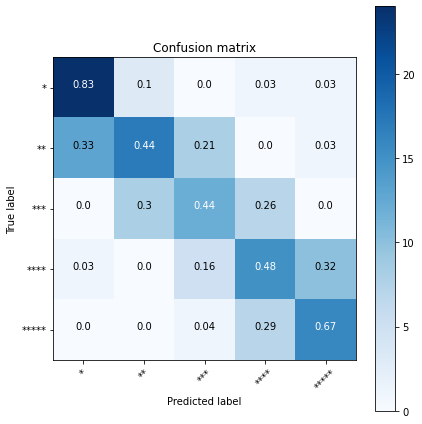

In [56]:
labels_to_int = {"*": 0, "**": 1, "***": 2, "****":3, "*****":4}

plot_confusion_matrix(confusion_matrix(y_preds, y_valid), class_names=labels_to_int.keys())
plt.show()

# Fine-tuning for Named Entity Recognition (NER)

In this part of the workshop we are going to learn how to fine-tune one of the 🤗 Transformers models to a token classification task. This is the task of predicting a label for each token. We will train a token classifier for the task of named entity recognition (NER).

An NER classifier classifies named entities mentioned in text as (person, organization, location or names of miscellaneous entities).

Setup some variables, the task in our case is `ner`, other options could be `pos` (part-of-speech-tagging) or `chunk` (chunking).

You can read more about the pre-trained model [distilbert](https://huggingface.co/distilbert-base-uncased) we are using.

🤗 Transformers provides scripts for different the NLP tasks. The next steps you will follow are essentially a breakdown of the classes and functions used in the `run_ner.py` script.

In [ ]:
task = "ner" # "ner", "pos" or "chunk"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16 # adjust where necessary

Next we load the `conll2003` dataset. You can read more about this training dataset [here](https://huggingface.co/datasets/conll2003)

In [ ]:
from datasets import load_dataset
datasets = load_dataset("conll2003")

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]


The datasets object is a `DatasetDict`, which contains one key for the `train`, `validation` and `test` sets.

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

Each of the datasets have a column for the `tokens` (the input texts split into words) and a column of `labels` for each of the tasks (pos, chunk ner).

Let's have a look at an element...

In [ ]:
datasets['train'][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

The labels are already coded as integer ids to be easily usable by our model, but the correspondence with the actual categories is stored in the `features` of the dataset:

In [ ]:
datasets["train"].features[f"ner_tags"]

Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

# NER tags: 

0 corresponds to 'O'

1 to 'B-PER' 

2 to 'I-PER' etc... 

In addition to the 'O' (which is means **no** special entity), there are **four** labels for NER, each prefixed with 'B-' (for beginning) or 'I-' (for intermediate), that indicate if the token is the first one for the current group with the label or not:

*   'PER' for person
*   'ORG' for organization
*   'LOC' for location
*   'MISC' for miscellaneous

Since the labels are lists of `ClassLabel`, the actual names of the labels are nested in the feature attribute of the object above:

In [ ]:
label_list = datasets['train'].features[f"{task}_tags"].feature.names
label_list

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset (automatically decoding the labels in passing)

In [ ]:
#@title
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))


In [ ]:
#@title
show_random_elements(datasets["train"])


,id,tokens,pos_tags,chunk_tags,ner_tags
0,5889,"[Manly, 42, Western, Suburbs, 12]","[RB, CD, NNP, NNP, CD]","[B-ADVP, B-NP, I-NP, I-NP, I-NP]","[B-ORG, O, B-ORG, I-ORG, O]"
1,482,"[Daniel, Nestor, (, Canada, ), beat, 1, -, Thomas, Muster, (, Austria, ), 6-3, 7-5]","[NNP, NNP, (, NNP, ), VB, CD, :, NNP, NNP, (, NNP, ), CD, CD]","[B-NP, I-NP, O, B-NP, O, B-VP, B-NP, I-NP, I-NP, I-NP, O, B-NP, O, B-NP, I-NP]","[B-PER, I-PER, O, B-LOC, O, O, O, O, B-PER, I-PER, O, B-LOC, O, O, O]"
2,7456,"[MEXICO, CITY, 1996-08-26]","[NNP, NNP, CD]","[B-NP, I-NP, I-NP]","[B-LOC, I-LOC, O]"
3,10154,"[3., Mariano, Friedick, (, U.S., ), 4:19.808]","[NNP, NNP, NNP, (, NNP, ), CD]","[B-NP, I-NP, I-NP, O, B-NP, O, B-NP]","[O, B-PER, I-PER, O, B-LOC, O, O]"
4,3953,"[Strasbourg, 1, (, Zitelli, 80th, ), Le, Havre, 0, .]","[NNP, CD, (, NNP, CD, ), NNP, NNP, CD, .]","[B-NP, I-NP, O, B-NP, I-NP, O, B-NP, I-NP, I-NP, O]","[B-ORG, O, O, B-PER, O, O, B-ORG, I-ORG, O, O]"


# Preprocessing the data

As previous, we now tokenize the inputs using a 🤗 Transformers Tokenizer. 

This means converting the `tokens` to their corresponding IDs in the pretrained **vocabulary**, and gets the data into a format the model expects, as well as generating the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer`.`from_pretrained` method, which will ensure:

* we get a tokenizer that corresponds to the model architecture we want to use,
* we download the vocabulary used when pretraining this specific checkpoint.
* That the vocabulary will be cached, so it's not downloaded again the next time we run the cell.



In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The next assertion makes sure that our tokenizer is a fast tokenize (backed by Rust) from the 🤗 Tokenizers library.

In [ ]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

Next try calling this tokenizer on an example sentence.

In [ ]:
tokenizer("This is an example boring sentence!")

{'input_ids': [101, 2023, 2003, 2019, 2742, 11771, 6251, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

If, as is the case here, your inputs have already been split into words, you should pass the list of words to your tokenzier with the argument `is_split_into_words=True`:

In [ ]:
tokenizer(["This", "is", "an", "example", "boring", "sentence", "split", "into", "words", "."], is_split_into_words=True)


{'input_ids': [101, 2023, 2003, 2019, 2742, 11771, 6251, 3975, 2046, 2616, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Note that transformers are often pretrained with subword tokenizers, meaning that even if your inputs have been split into words already, each of those words could be split again by the tokenizer. Let's look at an example of that:

In [ ]:
example = datasets["train"][4]
print(example["tokens"])

['Germany', "'s", 'representative', 'to', 'the', 'European', 'Union', "'s", 'veterinary', 'committee', 'Werner', 'Zwingmann', 'said', 'on', 'Wednesday', 'consumers', 'should', 'buy', 'sheepmeat', 'from', 'countries', 'other', 'than', 'Britain', 'until', 'the', 'scientific', 'advice', 'was', 'clearer', '.']


In [ ]:
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

['[CLS]', 'germany', "'", 's', 'representative', 'to', 'the', 'european', 'union', "'", 's', 'veterinary', 'committee', 'werner', 'z', '##wing', '##mann', 'said', 'on', 'wednesday', 'consumers', 'should', 'buy', 'sheep', '##me', '##at', 'from', 'countries', 'other', 'than', 'britain', 'until', 'the', 'scientific', 'advice', 'was', 'clearer', '.', '[SEP]']


Here the words "Zwingmann" and "sheepmeat" have been split in three subtokens.

This means that we need to do some processing on our labels as the **input ids** returned by the tokenizer are **longer** than the lists of labels our dataset contain. This is because some special tokens might be added (a [CLS] and a [SEP] above) and because of possible splits of words in multiple tokens:

In [ ]:
len(example[f"{task}_tags"]), len(tokenized_input["input_ids"])


(31, 39)

The tokenizer returns outputs that have a `word_ids` method which can help us.

In [ ]:
print(tokenized_input.word_ids())

[None, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 11, 11, 11, 12, 13, 14, 15, 16, 17, 18, 18, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, None]


As we can see, it returns a list with the same number of elements as our processed input ids, mapping special tokens to None and all other tokens to their respective word. This way, we can align the labels with the processed input ids.

In [ ]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"{task}_tags"][i] for i in word_ids]
print(len(aligned_labels), len(tokenized_input["input_ids"]))

39 39


Here we set the labels of all special tokens to -100 (the index that is ignored by PyTorch) and the labels of all other tokens to the label of the word they come from. 

Another strategy is to set the label only on the first token obtained from a given word, and give a label of -100 to the other subtokens from the same word. 

We propose the two strategies here, just change the value of the following flag:

In [ ]:
label_all_tokens = True


The following is a function that will preprocess the samples. 

Feed them to the tokenizer with the argument `truncation=True` (to truncate texts that are larger than the maximum size allowed by the model) and `is_split_into_words=True` (as above). Then align the labels with the token ids using the strategy picked:

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [ ]:
tokenize_and_align_labels(datasets['train'][:5])


{'input_ids': [[101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102], [101, 2848, 13934, 102], [101, 9371, 2727, 1011, 5511, 1011, 2570, 102], [101, 1996, 2647, 3222, 2056, 2006, 9432, 2009, 18335, 2007, 2446, 6040, 2000, 10390, 2000, 18454, 2078, 2329, 12559, 2127, 6529, 5646, 3251, 5506, 11190, 4295, 2064, 2022, 11860, 2000, 8351, 1012, 102], [101, 2762, 1005, 1055, 4387, 2000, 1996, 2647, 2586, 1005, 1055, 15651, 2837, 14121, 1062, 9328, 5804, 2056, 2006, 9317, 10390, 2323, 4965, 8351, 4168, 4017, 2013, 3032, 2060, 2084, 3725, 2127, 1996, 4045, 6040, 2001, 24509, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100], [-100, 1, 2, -100], [-100, 5, 0, 

We can apply this function on all the sentences (or pairs of sentences) in the dataset, by using the `map` method of our dataset object created earlier. 

This will apply the function on all the elements of all the splits in dataset, so our training, validation and testing data will be preprocessed in one single command.

Pass `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

In [ ]:
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_h

storing https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
creating metadata file for /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', '

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the batch_size defined earlier and customize the number of epochs for training, as well as the weight decay.

The last argument to setup everything so we can push the model to the Hub regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. 

Next is setting up a data collator that will batch the processed examples together while applying padding to make them all the same size (each pad will be padded to the length of its longest example). 

There is a data collator for this task in the Transformers library, that not only pads the inputs, but also the labels.

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=cb2492dd30c7ccd9a97b31184d79085c7ac81711bb0b7e74181a2067d5d4e4dc
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


Next is defining how to compute the metrics from the predictions in this NER example. We will load the seqeval metric via the Datasets library.

In [ ]:
from datasets import load_metric

metric = load_metric("seqeval")


This metric takes list of labels for the predictions and references:



In [ ]:
labels = [label_list[i] for i in example[f"{task}_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'LOC': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'PER': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

Next is some post-processing on the predictions:

* select the predicted index (with the maximum logit) for each token
* convert it to its string label
* ignore everywhere we set a label of -100

The following function does all this post-processing on the result of `Trainer.evaluate` (which is a namedtuple containing predictions and labels) before applying the metric:

In [ ]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

Drop the precision/recall/f1 computed for each category and only focus on the overall precision/recall/f1/accuracy.

Then pass all of this along with the datasets to the Trainer:

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
from transformers import TrainingArguments, Trainer

model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    overwrite_output_dir=True,
    #push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


# Setup the Trainer

In [ ]:
trainer = Trainer(
    model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

# Finetune the model

Now we can finetune the model by calling the train method.

In [ ]:
trainer.train()


The following columns in the training set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: chunk_tags, pos_tags, tokens, id, ner_tags. If chunk_tags, pos_tags, tokens, id, ner_tags are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14041
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2634


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.238600,0.067726,0.915702,0.919902,0.917797,0.981000
2,0.053700,0.061412,0.921858,0.937018,0.929376,0.983049
3,0.029800,0.060630,0.926994,0.938919,0.932918,0.983891


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: chunk_tags, pos_tags, tokens, id, ner_tags. If chunk_tags, pos_tags, tokens, id, ner_tags are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-ner/checkpoint-878
Configuration saved in distilbert-base-uncased-finetuned-ner/checkpoint-878/config.json
Model weights saved in distilbert-base-uncased-finetuned-ner/checkpoint-878/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-ner/checkpoint-878/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-ner/checkpoint-878/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForTokenClassificatio

TrainOutput(global_step=2634, training_loss=0.08558467725233862, metrics={'train_runtime': 257.1115, 'train_samples_per_second': 163.832, 'train_steps_per_second': 10.245, 'total_flos': 510709003547400.0, 'train_loss': 0.08558467725233862, 'epoch': 3.0})

# Push to hub (optional)

In [ ]:
trainer.push_to_hub()


# Save the model

In [ ]:
trainer.save_model("./ner_distilbert_model")

Saving model checkpoint to ./ner_distilbert_model
Configuration saved in ./ner_distilbert_model/config.json
Model weights saved in ./ner_distilbert_model/pytorch_model.bin
tokenizer config file saved in ./ner_distilbert_model/tokenizer_config.json
Special tokens file saved in ./ner_distilbert_model/special_tokens_map.json


# Evaluation

The evaluate method evaluates again on the evaluation dataset or on another dataset.

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: chunk_tags, pos_tags, tokens, id, ner_tags. If chunk_tags, pos_tags, tokens, id, ner_tags are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 16


{'eval_loss': 0.060630328953266144,
 'eval_precision': 0.926993593991606,
 'eval_recall': 0.9389193422083008,
 'eval_f1': 0.9329183571388874,
 'eval_accuracy': 0.9838912100656108,
 'eval_runtime': 6.2656,
 'eval_samples_per_second': 518.709,
 'eval_steps_per_second': 32.559,
 'epoch': 3.0}

# Metrics 

**Precision**: When the entity prediction is positive, how often is it correct?

**Recall**: When it actually is a positive entity, how often is the model correct? Or, What fraction of the positive entity labels does the model predict correctly?”

Precisionrecall.svg


By Walber - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=36926283


To get the **precision/recall/f1** computed for each **category** after having finished training, apply the same function as before on the result of the predict method:

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results


The following columns in the test set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: chunk_tags, pos_tags, tokens, id, ner_tags. If chunk_tags, pos_tags, tokens, id, ner_tags are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3250
  Batch size = 16


{'LOC': {'precision': 0.9465420560747664,
  'recall': 0.9671504965622613,
  'f1': 0.956735310787833,
  'number': 2618},
 'MISC': {'precision': 0.8103174603174603,
  'recall': 0.8294069861900893,
  'f1': 0.8197511039743074,
  'number': 1231},
 'ORG': {'precision': 0.8999037536092397,
  'recall': 0.9095330739299611,
  'f1': 0.9046927914852444,
  'number': 2056},
 'PER': {'precision': 0.9766524169681026,
  'recall': 0.978905735003296,
  'f1': 0.9777777777777779,
  'number': 3034},
 'overall_precision': 0.926993593991606,
 'overall_recall': 0.9389193422083008,
 'overall_f1': 0.9329183571388874,
 'overall_accuracy': 0.9838912100656108}

If you want to share your model you can upload the result of the training to the Hub, by executing: this instruction:

Now you can **share** the model using the model name and test it out using the `ner` pipeline discussed earlier in this workshop.

# Task

* Try to write code that makes use of the ner pipeline on your new model 
* Or you can use the trained and shared model on the Hub by Jennifer, which can be found here: `"jenniferjane/ner_trainer"`
* Print out the labels for an example sentence.

In [ ]:
from transformers import ...

model = None
tokenizer = None
ner_pipe = None
sequence = " "


# Solution

In [ ]:
#@title
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

model = AutoModelForTokenClassification.from_pretrained("jenniferjane/ner_trainer")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
ner_pipe = pipeline("ner", model=model, tokenizer=tokenizer)
sequence = 'Jennifer loves dining at Hoppers in Marylebone, London.'

In [ ]:
#@title
for entity in ner_pipe(sequence):
  print(entity)